In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [3]:
#build vocabulary of characters and mappings to/from intergers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3
def build_dataset(words):
	
	X, Y = [], []
	
	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			#print(''.join(itos[i] for i in context), '--->',itos[ix])
			context =context[1:] + [ix]

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
#MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),				generator=g)
W1 = torch.randn((n_emb * block_size,n_hidden),	generator=g) 
b1 = torch.randn(n_hidden,						generator=g) 
W2 = torch.randn((n_hidden,vocab_size),			generator=g) 
b2 = torch.randn(vocab_size,					generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [36]:
max_steps = 50000
batch_size =32
lossi = []

for i in range(max_steps):	

	# mini-batch construct 
	ix= torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
	hpreact = embcat @ W1 + b1 # hidden layer pre-activation
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 #output layer
	loss = F.cross_entropy(logits, Yb)
	
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1 if i < 10000 else 0.01
	for p in parameters:
		p.data += - lr * p.grad
	
	# track stats
	if i % 10000 ==0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

      0/  50000: 27.8817
  10000/  50000: 2.9068
  20000/  50000: 2.5667
  30000/  50000: 2.6291
  40000/  50000: 1.9968


### Fixing Initial Loss

* In the first 10000 steps the loss goes from 27.88 to 2.9, this makes the NN to not learn efficientlly due to it's initialization.
* The NN is initialized in a way that is wrongly confident that's why the loss is soo high
* In reality the loss initially should be 1/27, since it hasn´t learn anything

In [7]:
-torch.tensor(1/27.0).log() # This should be the initial loss

tensor(3.2958)

In [25]:
# 4 dimensional example of the issue
# in our NN at initialization we hava randon weights and biases
logits = torch.randn(4) * 10 # 10 represents what comes from hidden layer

# but based on this proble we want the logits to come out roughly as 0 (1/27)
logits_wanted = torch.tensor([0.0, 0.0, 0.0, 0.0])

probs = torch.softmax(logits, dim=0)
probs_wanted = torch.softmax(logits_wanted, dim=0)

loss = -probs[2].log()
loss_wanted = -probs_wanted[2].log()
print(probs, loss)
print(probs_wanted, loss_wanted)

tensor([3.2775e-09, 2.6915e-12, 1.0000e+00, 4.2632e-11]) tensor(-0.)
tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)


* To solve this issue we multiply w2 by 0.01 and b2 by 0.0 so they can start with number close to 0

In [41]:
#MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),				generator=g)
W1 = torch.randn((n_emb * block_size,n_hidden),	generator=g)
b1 = torch.randn(n_hidden,						generator=g) 
W2 = torch.randn((n_hidden,vocab_size),			generator=g) * 0.01 # initial weights very close to 0 so it gives same probability to all letters
b2 = torch.randn(vocab_size,					generator=g) * 0 # we want to start without a bias in the initialization same reason as above


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [42]:
max_steps = 50000
batch_size =32
lossi = []

for i in range(max_steps):	

	# mini-batch construct 
	ix= torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
	hpreact = embcat @ W1 + b1 # hidden layer pre-activation
	
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 #output layer
	loss = F.cross_entropy(logits, Yb)
	
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1 if i < 10000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	# track stats
	if i % 10000 ==0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	break

      0/  50000: 3.3221


* Now we have values much closer to want we wanted at initilization
3.31 vc -torch.tensor(1/27.0).log()=3.29

### Kaiming Init

The next issue that we will address is the saturation of the activation function, the idea of the activation function is the NN to learn so the activation function needs to work on the slope and not on the tails, we need to make sure that our initialization doesn't make the NN to operate from the beggining on the long tail of the tanh. Let's check this:

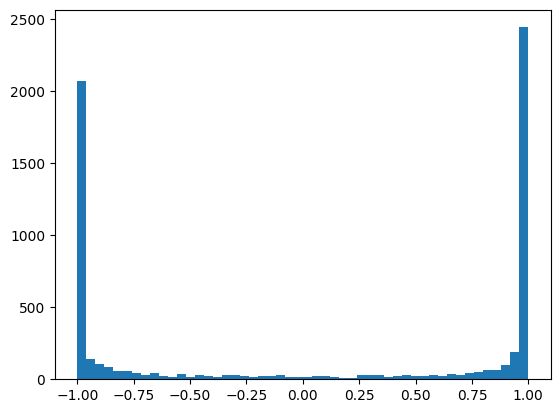

In [43]:
plt.hist(h.view(-1).tolist(),50);

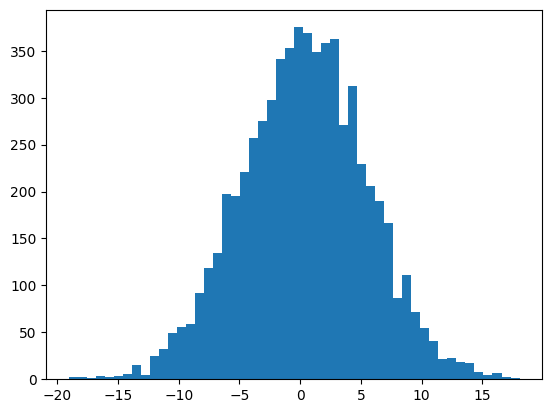

In [44]:
# Let's see what feeds the tanh()
plt.hist(hpreact.view(-1).tolist(),50);

The results show that hpreactivation has a wide range of values between [-15,15] making the tanh to squash all values above and below -1 and 1.
Let's see how many points are actually in the flat region of tanh:

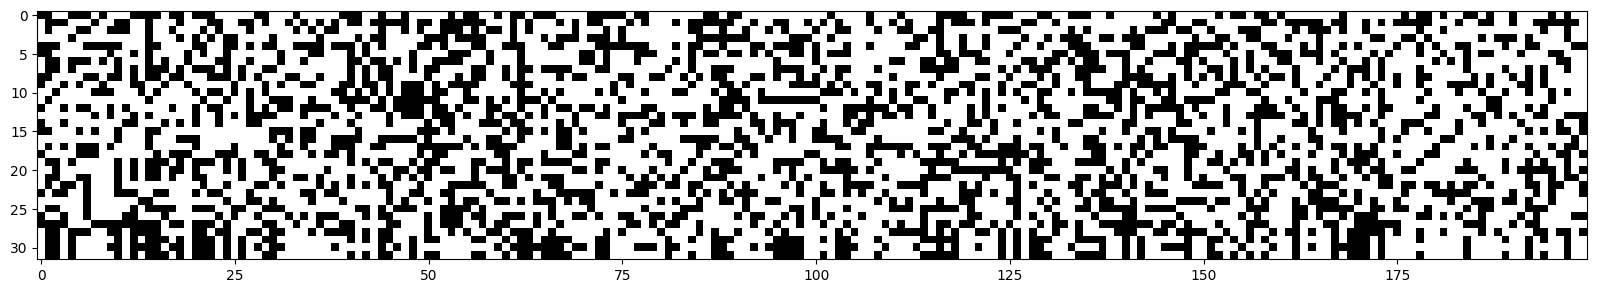

In [45]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In the case of all single example (32) dont activate the neuron (white color) it means that we have a dead neuron that would never learn during training.
We want hpreact to be close to zero to make tanh work on the slope. To do this we can have the bias b1 close to 0 and squash w1 (multiply by 0.1)
This is not scalable for deep neural nets to multiple every weight by a special value, a way to fix this is with Kaiming init.

* Kaiming init - Fixes the problem of when multipling two normal distrib samples the standard deviation jumps too high and needs to be "corrected" with a gain to compensate the fact that tanh is a contracting force that squeezes hpreact, in order to fight this squeezing we need to boost the w coefficient to have standard deviation of ~1. Based on each activation functions we have different gains 

tensor(0.0015) tensor(0.9979)
Without kaiming init-  tensor(-0.0021) tensor(3.1853)
With kaiming init-  tensor(-0.0002) tensor(0.9838)


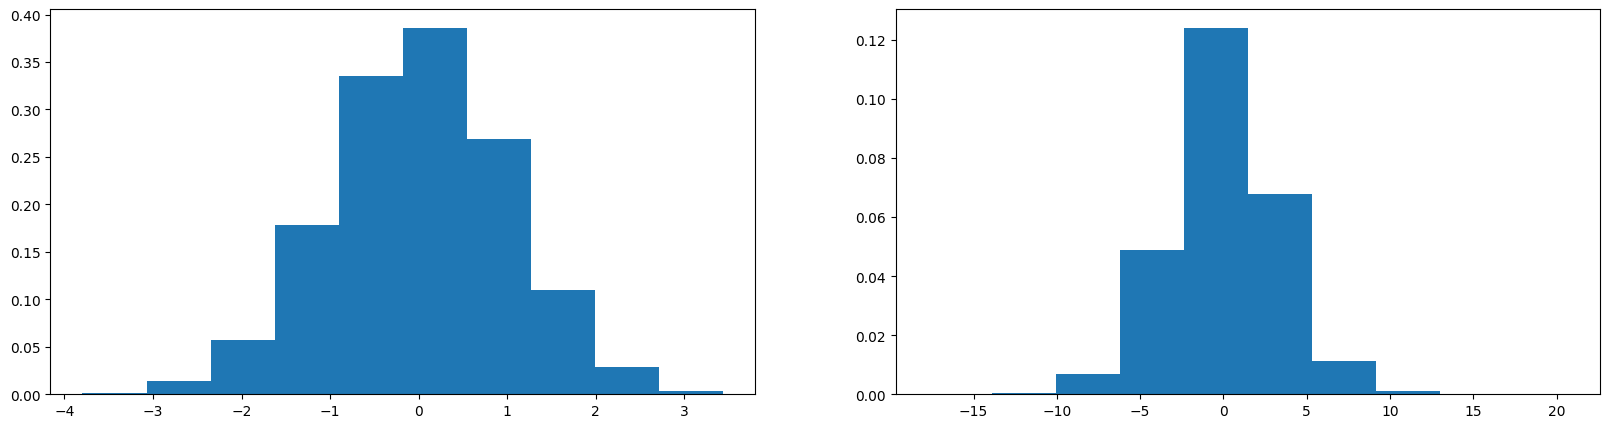

In [50]:
# How to choose the initializetion scalers of W1,b1
x = torch.randn(1000,10) # gaussian random
w = torch.randn(10,200) 
w_kinit = torch.randn(10,200) / 10**(0.5) # kaiming init (square root(10) ==10 ** 0.5)
y= x @ w    # when multiplying the weights by the inputs we go from standard deviatio  = 1 to std 3
y_kinit= x @ w_kinit
print(x.mean(),x.std()) 
print('Without kaiming init- ',y.mean(), y.std())
print('With kaiming init- ',y_kinit.mean(), y_kinit.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), density=True);
# when multiplying the weights by the inputs we go from std = 1 to std =3 which ultimatly will make influence tanh(), we want to keep the std low by this we need to multiply W

In [ ]:
# The correction is: gain / sqrt(fan-in)
# For tanh the gain is:
(5/3) / (n_emb*block_size)  #fan-in is the input shape to the weight matrix

In [62]:
#MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),				generator=g)
W1 = torch.randn((n_emb * block_size,n_hidden),	generator=g) * ((5/3) / (n_emb*block_size)**0.5) # kaiming init :) 
b1 = torch.randn(n_hidden,						generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),			generator=g) * 0.01 # initial weights very close to 0 so it gives same probability to all letters
b2 = torch.randn(vocab_size,					generator=g) * 0 # we want to start without a bias in the initialization same reason as above


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [63]:
max_steps = 50000
batch_size =32
lossi = []

for i in range(max_steps):	

	# mini-batch construct 
	ix= torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
	hpreact = embcat @ W1 + b1 # hidden layer pre-activation
	
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 #output layer
	loss = F.cross_entropy(logits, Yb)
	
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1 if i < 10000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	# track stats
	if i % 10000 ==0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	break

      0/  50000: 3.3179


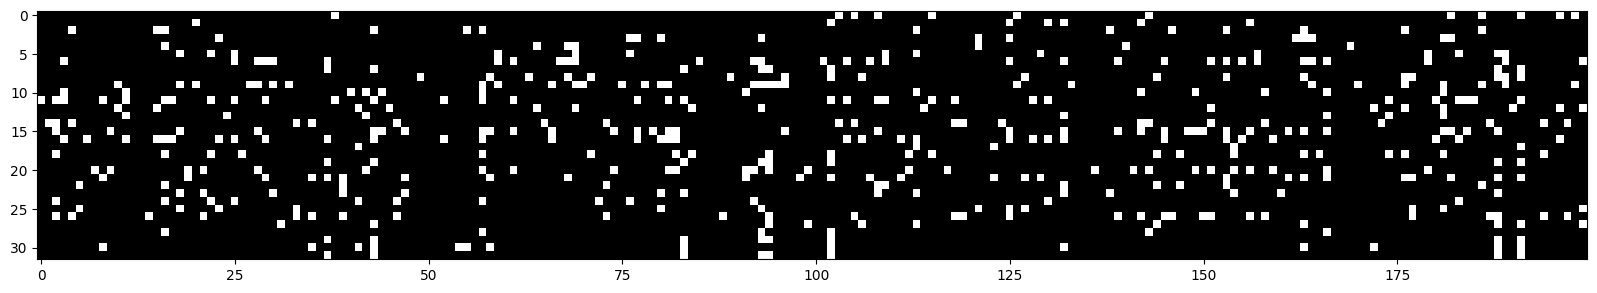

In [64]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Kaiming init really help us out fizing the tanh and now we have most of the neurons working in the slope (black points)

### Batch Norm

The necessity to have all hpreact normalized made it very difficult to set up all the initiation weights for large and deep neural network. In order to solve this an idea came of normalizing to gaussian every linear layer (because of its multiplication) for a normal distribution, this is possible since the operations to reach this are differenciable and backprop works fine.

We let the gaussian too "move aroud" by adding a gain and a bias so that the NN can learn make it slighly less contrained - this learning is based on the batch randomly selected making it act as a regularization effect since as we train it will see different batches making the hpreact layer move slighly as function of the batch 

In [68]:
#MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),				generator=g)
#--------------- Kaiming Init-------------------#
W1 = torch.randn((n_emb * block_size,n_hidden),	generator=g) * ((5/3) / (n_emb*block_size)**0.5) # kaiming init 
#b1 = torch.randn(n_hidden,						generator=g) * 0.01 #remove since batchNorm already introduces a bias (bnbias)
#----------------- Initial Loss fix-------------#
W2 = torch.randn((n_hidden,vocab_size),			generator=g) * 0.01 # initial weights very close to 0 so it gives same probability to all letters
b2 = torch.randn(vocab_size,					generator=g) * 0 # we want to start without a bias in the initialization same reason as above

#-----------------BATCH NORM -------------------#
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1,n_hidden))
#global mean and std
bnmean = torch.zeros((1,n_hidden))
bnstd = torch.ones((1,n_hidden))

#batch norm - gain and bias learn through backprop 
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [67]:
max_steps = 200000
batch_size =32
lossi = []

for i in range(max_steps):	

	# mini-batch construct 
	ix= torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
	hpreact = embcat @ W1 #+ b1 # In the batchNorm layer we already introduce a bias to hpreact (bnbias)
	# --------------- BatchNorm layer -------------------------
	bnmeani = hpreact.mean(0, keepdim=True)
	bnstdi = hpreact.std(0, keepdim=True)
	# centering operation to make it gaussian - bngain and bnbias to make NN to shift 
	hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
	# parallel compute of the global mean and std for the final run for inference - train/dev/test set
	# this ones are not trained with the NN
	with torch.no_grad(): 
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
	
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 #output layer
	loss = F.cross_entropy(logits, Yb)
	
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1 if i < 10000 else 0.01
	for p in parameters:
		p.data += - lr * p.grad
	
	# track stats
	if i % 10000 ==0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.2950
  30000/ 200000: 2.3937
  40000/ 200000: 1.9780
  50000/ 200000: 2.4495
  60000/ 200000: 2.4431
  70000/ 200000: 2.0071
  80000/ 200000: 2.2948
  90000/ 200000: 2.1144
 100000/ 200000: 2.0097
 110000/ 200000: 2.3772
 120000/ 200000: 2.0301
 130000/ 200000: 2.4808
 140000/ 200000: 2.4385
 150000/ 200000: 2.2068
 160000/ 200000: 2.0353
 170000/ 200000: 1.8832
 180000/ 200000: 2.0849
 190000/ 200000: 1.8312


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.118706464767456
val 2.145137071609497


In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

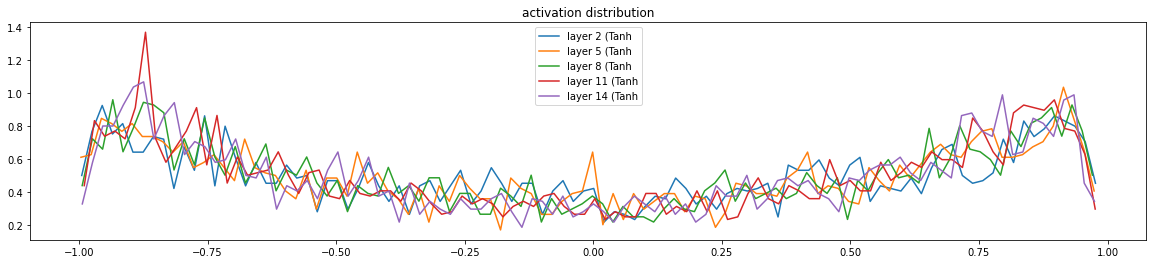

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245583e-03
layer 8 (      Tanh): mean -0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

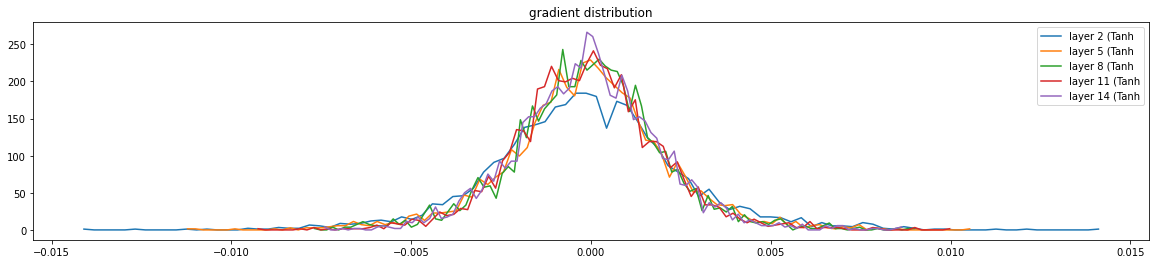

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241074e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132876e-03 | grad:data ratio 6.964616e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672205e-03 | grad:data ratio 5.570125e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


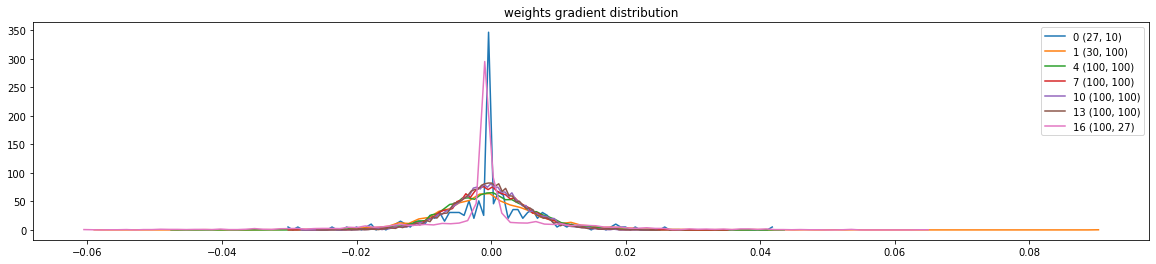

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

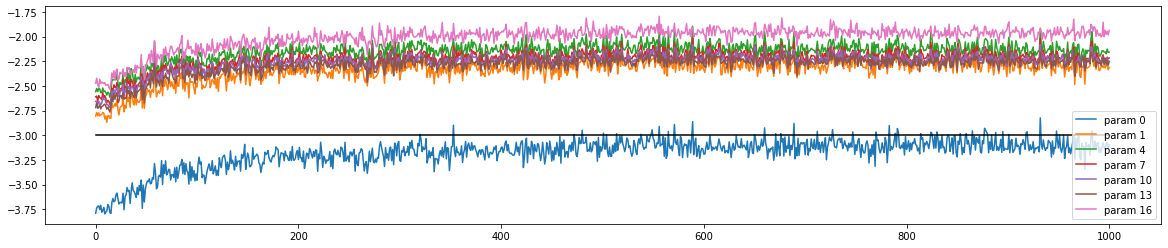

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188
